Device: cuda

------------------------------------------------------------------------------------------
 >>> Starting LOSO (count-only, K-auto) + WINDOWING + TEST time-warp SWEEP
------------------------------------------------------------------------------------------

 >>> SWEEP | Activity: Knees bending (act_id=8)


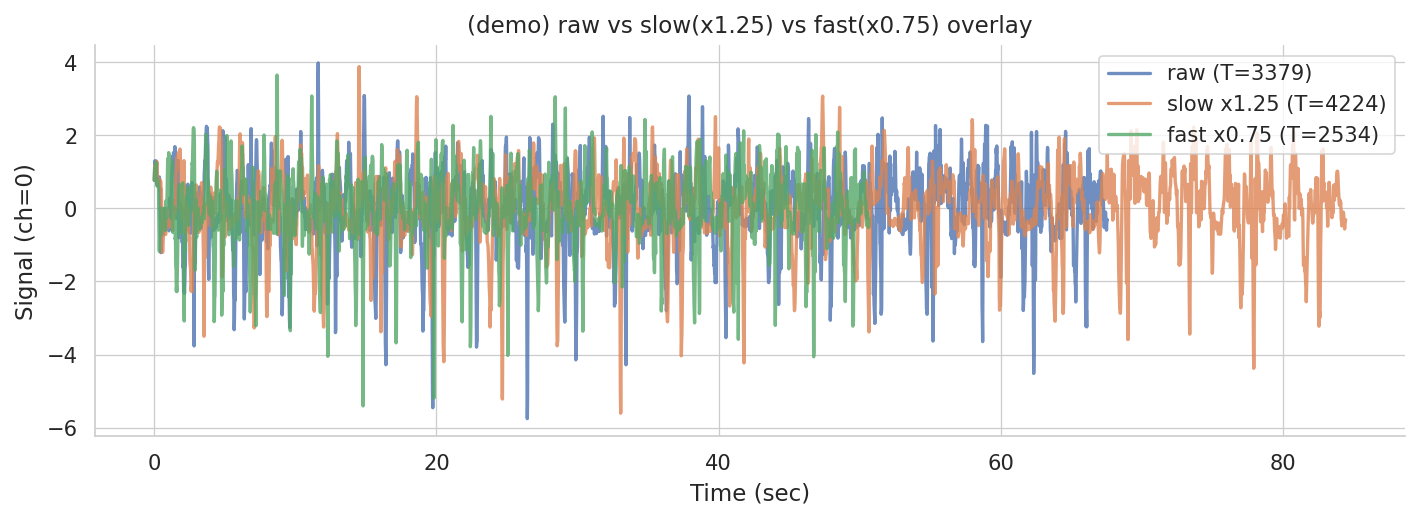

[Knees bending] Fold  1 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  2 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  3 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  4 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  5 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  6 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  7 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  8 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  9 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold 10 done (trained on 9 subj, swept 10 mults)
[Saved] sweep rows -> sweep_results/sweep_act8_Knees_bending.csv

------------------------------------------------------------------------------------------
[Knees bending] ALL SWEEP ROWS (Subject × mult) | n=100
------------------------------------------------------------------------------------------
 mult   Subject   GT      Pred       MAE    MA

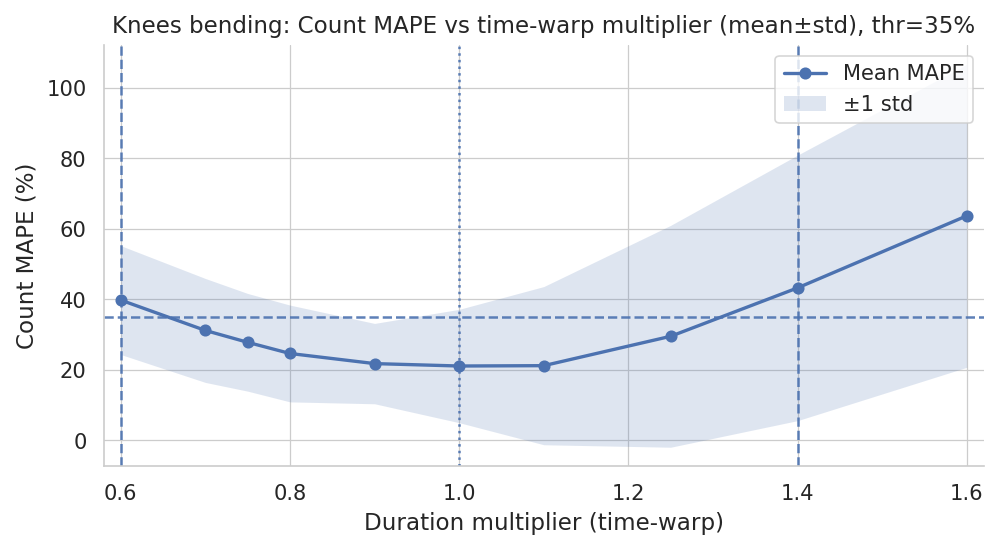

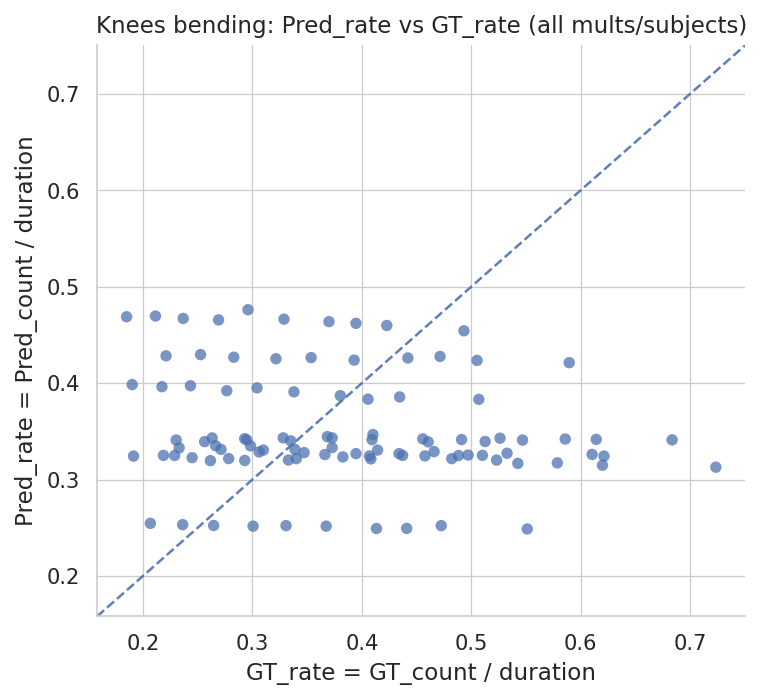


 >>> SWEEP | Activity: Jogging (act_id=10)
[Jogging] Fold  1 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  2 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  3 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  4 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  5 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  6 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  7 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  8 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold  9 done (trained on 9 subj, swept 10 mults)
[Jogging] Fold 10 done (trained on 9 subj, swept 10 mults)
[Saved] sweep rows -> sweep_results/sweep_act10_Jogging.csv

------------------------------------------------------------------------------------------
[Jogging] ALL SWEEP ROWS (Subject × mult) | n=100
------------------------------------------------------------------------------------------
 mult   Subject    GT       Pred        MAE   MAPE(%)       Bias  GT_rate

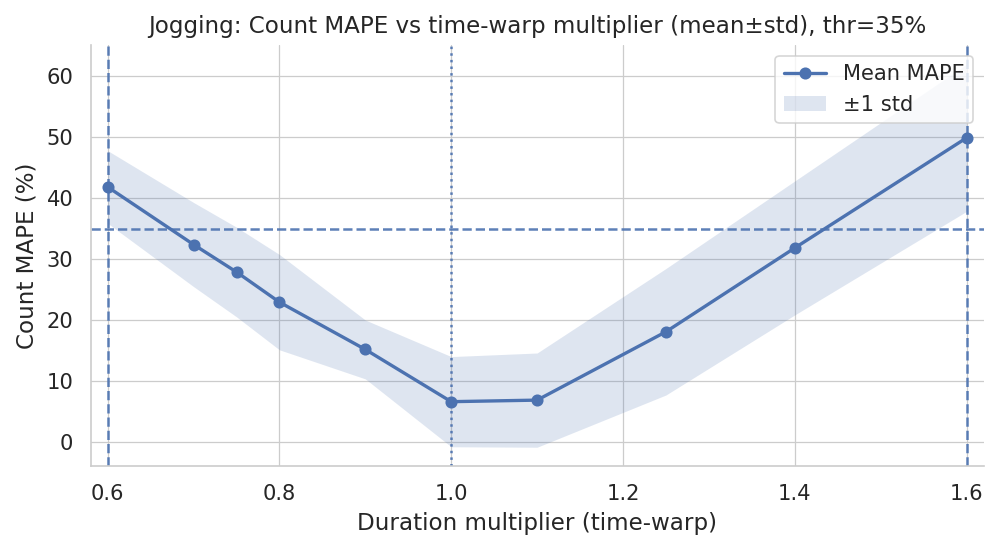

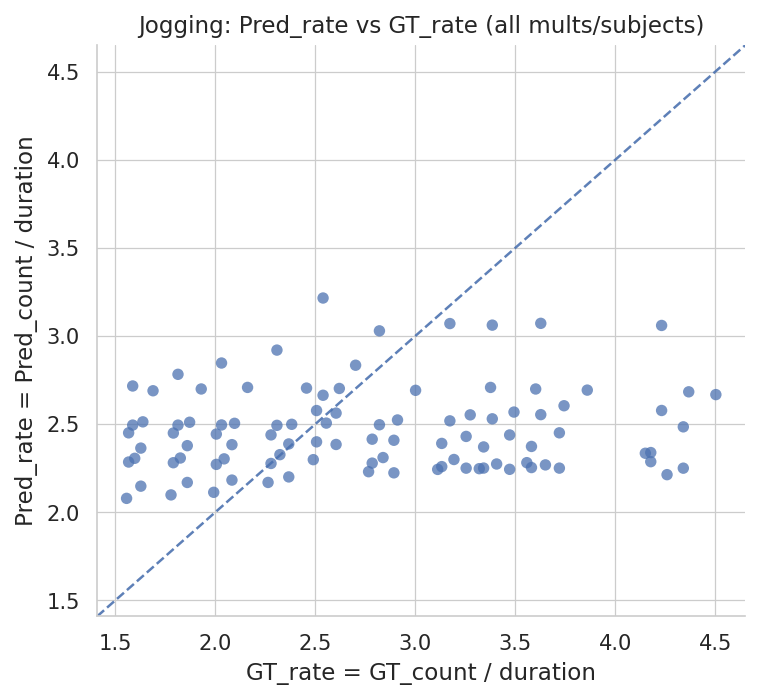


 >>> SWEEP | Activity: Jump front & back (act_id=12)
[Jump front & back] Fold  1 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  2 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  3 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  4 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  5 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  6 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  7 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  8 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold  9 done (trained on 9 subj, swept 10 mults)
[Jump front & back] Fold 10 done (trained on 9 subj, swept 10 mults)
[Saved] sweep rows -> sweep_results/sweep_act12_Jump_front_and_back.csv

------------------------------------------------------------------------------------------
[Jump front & back] ALL SWEEP ROWS (Subject × mult) | n=100
--------------------------------

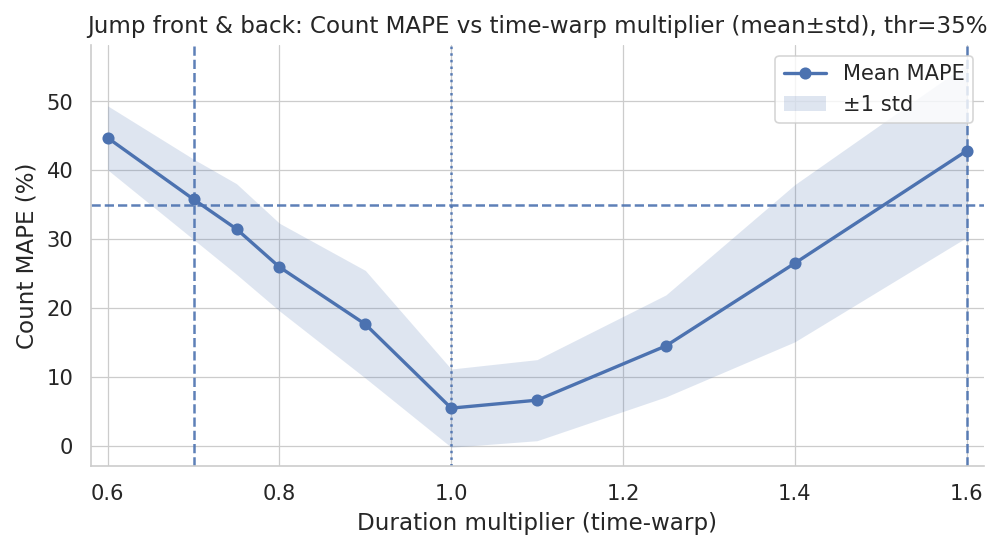

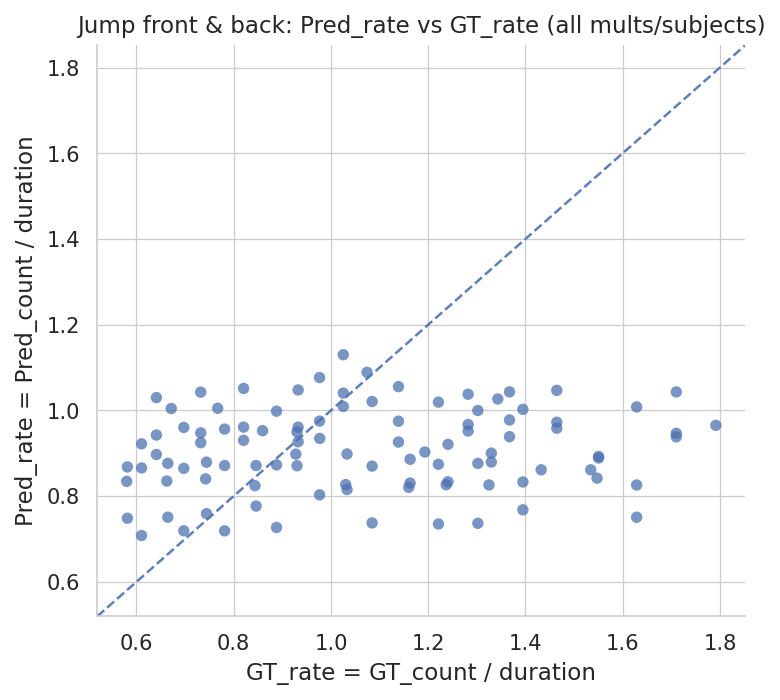

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


# ---------------------------------------------------------------------
# Paper-style visualization
# ---------------------------------------------------------------------
def set_paper_style():
    sns.set_theme(context="paper", style="whitegrid", font="DejaVu Sans", font_scale=1.15)
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "lines.linewidth": 1.6,
        "legend.frameon": True,
    })


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score (trial-wise)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,              # (T,C)
                'count': float(gt_count),      # trial total count
                'meta': f"{subj}_{act_name}",
                'subj': subj,
                'act_id': act_id,
            })
        else:
            pass

    return trial_list


# ---------------------------------------------------------------------
# 2.5) Windowing
# ---------------------------------------------------------------------
def trial_list_to_windows(trial_list, fs, win_sec=8.0, stride_sec=4.0, drop_last=True):
    """
    TRAIN 전용: trial -> sliding windows
    window 라벨은 trial 평균 rate로부터 생성:
      rate_trial = count_total / total_duration
      count_window = rate_trial * window_duration
    """
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    assert win_len > 0 and stride > 0

    windows = []
    for item in trial_list:
        x = item["data"]  # (T,C)
        T = x.shape[0]
        total_count = float(item["count"])
        meta = item["meta"]

        total_dur = max(T / float(fs), 1e-6)
        rate_trial = total_count / total_dur  # reps/s

        if T < win_len:
            win_dur = T / float(fs)
            windows.append({
                "data": x,
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[0:{T}]",
            })
            continue

        last_start = T - win_len
        starts = list(range(0, last_start + 1, stride))

        for st in starts:
            ed = st + win_len
            win_dur = win_len / float(fs)
            windows.append({
                "data": x[st:ed],
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[{st}:{ed}]",
            })

        if not drop_last:
            last_st = starts[-1] + stride
            if last_st < T:
                ed = T
                win_dur = (ed - last_st) / float(fs)
                windows.append({
                    "data": x[last_st:ed],
                    "count": rate_trial * win_dur,
                    "meta": f"{meta}__win[{last_st}:{ed}]",
                })

    return windows


def predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    """
    TEST 전용: trial -> windows inference -> window rate 평균 -> total count
    x_np: (T,C) numpy (정규화된 상태)
    return: pred_count(float)
    """
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]
    total_dur = T / float(fs)

    # short trial -> 1회 forward
    if T <= win_len:
        x_tensor = torch.tensor(x_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)  # (1,C,T)
        with torch.no_grad():
            rate_hat, _, _, _ = model(x_tensor, mask=None, tau=tau)
        pred_count = float(rate_hat.item() * total_dur)
        return pred_count

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)  # (N, win_len, C)
    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)  # (N,C,win_len)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())

    rates = np.concatenate(rates, axis=0)  # (N,)
    rate_mean = float(rates.mean())
    pred_count = rate_mean * total_dur
    return float(pred_count)


# ---------------------------------------------------------------------
# 2.6) ✅ Time-warp (TEST only)
# ---------------------------------------------------------------------
def time_warp_linear(x_np: np.ndarray, dur_mult: float) -> np.ndarray:
    """
    x_np: (T, C) float32
    dur_mult > 1.0  => 느리게(길어짐, T 증가)
    dur_mult < 1.0  => 빠르게(짧아짐, T 감소)

    구현: time axis 선형 보간 resample (채널별 독립)
    """
    assert x_np.ndim == 2, f"x_np must be (T,C), got {x_np.shape}"
    T, C = x_np.shape
    new_T = int(round(T * float(dur_mult)))
    new_T = max(new_T, 2)

    t_old = np.linspace(0.0, 1.0, T, dtype=np.float32)
    t_new = np.linspace(0.0, 1.0, new_T, dtype=np.float32)

    out = np.zeros((new_T, C), dtype=np.float32)
    for c in range(C):
        out[:, c] = np.interp(t_new, t_old, x_np[:, c]).astype(np.float32)
    return out


def plot_warp_overlay(raw_x, slow_x, fast_x, fs, ch=0, title="Time-warp overlay (raw/slow/fast)"):
    # 논문에 싣는 용도라기보단 데모/검증용이므로 너무 크지 않게 조정
    t_raw  = np.arange(raw_x.shape[0])  / float(fs)
    t_slow = np.arange(slow_x.shape[0]) / float(fs)
    t_fast = np.arange(fast_x.shape[0]) / float(fs)

    fig, ax = plt.subplots(figsize=(9.6, 3.6))
    ax.plot(t_raw,  raw_x[:, ch],  alpha=0.8, label=f"raw (T={raw_x.shape[0]})")
    ax.plot(t_slow, slow_x[:, ch], alpha=0.8, label=f"slow x1.25 (T={slow_x.shape[0]})")
    ax.plot(t_fast, fast_x[:, ch], alpha=0.8, label=f"fast x0.75 (T={fast_x.shape[0]})")
    ax.set_title(title)
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel(f"Signal (ch={ch})")
    ax.legend(loc="upper right")
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


# ---------------------------------------------------------------------
# 2.8) Dataset / Collate
# ---------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),         # (B, C, T_max)
        "mask": torch.stack(masks),               # (B, T_max)
        "count": torch.stack(counts),             # (B,)
        "length": torch.tensor(lengths, dtype=torch.float32),  # (B,)
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        z = self.net(x)            # (B,D,T)
        z = z.transpose(1, 2)      # (B,T,D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        zt = z.transpose(1, 2)     # (B,D,T)
        x_hat = self.net(zt)       # (B,C,T)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)  # [amp | phase_logits...]
        )

    def forward(self, z, tau=1.0):
        out = self.net(z)                     # (B,T,1+K)
        amp = F.softplus(out[..., 0])         # (B,T) >=0
        phase_logits = out[..., 1:]           # (B,T,K)
        phase = F.softmax(phase_logits / tau, dim=-1)
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        z = self.encoder(x)              # (B,T,D)
        x_hat = self.decoder(z)          # (B,C,T)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=tau)
        micro_rate_t = amp_t             # (B,T)

        p_bar = self._masked_mean_time(phase_p, mask)           # (B,K)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)          # (B,)

        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6) # (B,T)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "phase_p": phase_p,          # (B,T,K)
            "rep_rate_t": rep_rate_t,    # (B,T)
            "k_hat": k_hat,              # (B,)
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)              # (B,1,T)
    se = (x_hat - x) ** 2                    # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    dv = torch.abs(v[:, 1:] - v[:, :-1])
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)  # (B,T)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    if mask is None:
        p_bar = phase_p.mean(dim=1)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)
    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean()


def compute_phase_entropy_mean(phase_p_np, eps=1e-8):
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)  # (T,K)
    ent_t = -(phase_p_np * np.log(phase_p_np + eps)).sum(axis=1)
    return float(ent_t.mean())


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)
        mask = batch["mask"].to(device)
        y_count = batch["count"].to(device)
        length = batch["length"].to(device)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration

        optimizer.zero_grad()
        rate_hat, _, x_hat, aux = model(x, mask, tau=tau)

        loss_rate = F.mse_loss(rate_hat, y_rate)
        loss_recon = masked_recon_mse(x_hat, x, mask)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)
        loss_effk = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()


# ---------------------------------------------------------------------
# 6) ✅ Added helpers for SWEEP + breakpoint + plots
# ---------------------------------------------------------------------
def _safe_div(a, b, eps=1e-6):
    return a / (b + eps)


def _find_breakpoints_by_mape(group_df, mape_thr=35.0):
    """
    group_df columns expected: ['mult', 'MAPE_mean'] sorted by mult
    return: (bp_fast, bp_slow)
      - bp_fast: mult < 1 side, moving away from 1: 1.0 -> ... -> smaller
      - bp_slow: mult > 1 side, moving away from 1: 1.0 -> ... -> larger
    """
    fast = group_df[group_df["mult"] < 1.0].sort_values("mult", ascending=False)
    bp_fast = None
    for _, r in fast.iterrows():
        if float(r["MAPE_mean"]) > float(mape_thr):
            bp_fast = float(r["mult"])
            break

    slow = group_df[group_df["mult"] > 1.0].sort_values("mult", ascending=True)
    bp_slow = None
    for _, r in slow.iterrows():
        if float(r["MAPE_mean"]) > float(mape_thr):
            bp_slow = float(r["mult"])
            break

    return bp_fast, bp_slow


def plot_sweep_mape_vs_mult(group_df, title, mape_thr=35.0, bp_fast=None, bp_slow=None):
    """
    (논문 스타일) mean line + ±std band + threshold/bp lines
    group_df expected columns: ['mult','MAPE_mean','MAPE_std'] sorted by mult
    """
    x = group_df["mult"].values.astype(np.float32)
    y = group_df["MAPE_mean"].values.astype(np.float32)
    s = group_df["MAPE_std"].values.astype(np.float32)
    s = np.nan_to_num(s, nan=0.0)

    fig, ax = plt.subplots(figsize=(6.8, 3.8))

    ax.plot(x, y, marker="o", zorder=3, label="Mean MAPE")
    ax.fill_between(x, y - s, y + s, alpha=0.18, linewidth=0, zorder=2, label="±1 std")

    ax.axvline(1.0, linestyle=":", linewidth=1.2, alpha=0.9)
    ax.axhline(float(mape_thr), linestyle="--", linewidth=1.2, alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel("Duration multiplier (time-warp)")
    ax.set_ylabel("Count MAPE (%)")
    ax.margins(x=0.02)

    y_top = ax.get_ylim()[1]

    if bp_fast is not None:
        ax.axvline(float(bp_fast), linestyle="--", linewidth=1.2, alpha=0.9)
    if bp_slow is not None:
        ax.axvline(float(bp_slow), linestyle="--", linewidth=1.2, alpha=0.9)

    ax.legend(loc="upper right")
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def plot_predrate_vs_gtrate(df_all, title, hue_mult=False):
    """
    (논문 스타일) scatter + y=x line + equal limits
    df_all columns expected: ['GT_rate','Pred_rate','mult']
    """
    fig, ax = plt.subplots(figsize=(5.2, 4.8))

    if hue_mult:
        sns.scatterplot(
            data=df_all, x="GT_rate", y="Pred_rate",
            hue="mult", palette="viridis",
            s=30, alpha=0.75, edgecolor="none", ax=ax
        )
        ax.legend(title="mult", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    else:
        sns.scatterplot(
            data=df_all, x="GT_rate", y="Pred_rate",
            s=30, alpha=0.75, edgecolor="none", ax=ax
        )

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lo = float(min(xmin, ymin))
    hi = float(max(xmax, ymax))

    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.2, alpha=0.9)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    ax.set_title(title)
    ax.set_xlabel("GT_rate = GT_count / duration")
    ax.set_ylabel("Pred_rate = Pred_count / duration")

    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def _summarize_subjectwise_for_mult(df_act, mult, exp_name):
    dfm = df_act[np.isclose(df_act["mult"].values.astype(np.float32), float(mult), atol=1e-6)].copy()
    if len(dfm) == 0:
        return None, None

    df_subj = dfm.sort_values("Subject_ID").reset_index(drop=True)[
        ["Subject", "Pred", "GT", "MAE", "MAPE(%)", "Bias", "k_hat"]
    ].copy()

    mae_mean, mae_std = df_subj["MAE"].mean(), df_subj["MAE"].std()
    mape_mean, mape_std = df_subj["MAPE(%)"].mean(), df_subj["MAPE(%)"].std()
    bias_mean, bias_std = df_subj["Bias"].mean(), df_subj["Bias"].std()
    kh_mean, kh_std = df_subj["k_hat"].mean(), df_subj["k_hat"].std()

    summary = {
        "Experiment": exp_name,
        "MAE_mean": mae_mean, "MAE_std": mae_std,
        "MAPE_mean": mape_mean, "MAPE_std": mape_std,
        "Bias_mean": bias_mean, "Bias_std": bias_std,
        "k_hat_mean": kh_mean, "k_hat_std": kh_std,
        "n": len(df_subj)
    }
    return df_subj, summary


# ---------------------------------------------------------------------
# 7) Main
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],

        "TARGET_ACTIVITIES_MAP": {
            8: 'Knees bending',
            10: 'Jogging',
            12: 'Jump front & back'
        },

        "ACT_FEATURE_MAP": {
            8: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            10: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ]
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Windowing Params
        "win_sec": 8.0,
        "stride_sec": 4.0,
        "drop_last": True,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.0075,

        "tau": 1.0,

        # ✅ dict 형태 GT
        "ALL_LABELS_DICT": {
            8: {
                "subject1": 20, "subject2": 21, "subject3": 21, "subject4": 19, "subject5": 20,
                "subject6": 20, "subject7": 21, "subject8": 21, "subject9": 21, "subject10": 21,
            },
            10: {
                "subject1": 157, "subject2": 161, "subject3": 154, "subject4": 154, "subject5": 160,
                "subject6": 156, "subject7": 153, "subject8": 160, "subject9": 166, "subject10": 156,
            },
            12: {
                "subject1": 20, "subject2": 22, "subject3": 21, "subject4": 21, "subject5": 20,
                "subject6": 21, "subject7": 19, "subject8": 20, "subject9": 20, "subject10": 20,
            },
        },
    }

    # ------------------------------------------------------------------
    # ✅ Sweep config (요구사항)
    # ------------------------------------------------------------------
    SWEEP_MULTS = [0.6, 0.7, 0.75, 0.8, 0.9, 1.0, 1.1, 1.25, 1.4, 1.6]
    MAPE_BREAKPOINT = 35.0  # ✅ fixed

    # (원 코드 유지) 결과 csv 저장 경로
    OUT_DIR = "sweep_results"
    os.makedirs(OUT_DIR, exist_ok=True)

    set_paper_style()

    # ------------------------------------------------------------------
    # helper: dict -> label_config(list of tuples)
    # ------------------------------------------------------------------
    def labels_from_dict(labels_dict, act_id, include_subjects):
        out = []
        for subj in include_subjects:
            if subj not in labels_dict[act_id]:
                print(f"[Skip] Missing GT count for {subj} act_id={act_id}")
                continue
            out.append((subj, act_id, float(labels_dict[act_id][subj])))
        return out

    # ------------------------------------------------------------------
    # init
    # ------------------------------------------------------------------
    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]

    print("\n" + "-" * 90)
    print(" >>> Starting LOSO (count-only, K-auto) + WINDOWING + TEST time-warp SWEEP")
    print("-" * 90)

    # ------------------------------------------------------------------
    # ✅ Activity-wise sweep (train once per fold, test multiple mults)
    # ------------------------------------------------------------------
    for act_id in [8, 10, 12]:
        act_name = CONFIG["TARGET_ACTIVITIES_MAP"][act_id]
        print("\n" + "=" * 90)
        print(f" >>> SWEEP | Activity: {act_name} (act_id={act_id})")
        print("=" * 90)

        rows = []

        for fold_idx, test_subj in enumerate(subjects):
            set_strict_seed(CONFIG["seed"])

            train_subjects = [s for s in subjects if s != test_subj]
            test_subjects = [test_subj]

            train_labels = labels_from_dict(CONFIG["ALL_LABELS_DICT"], act_id, train_subjects)
            test_labels = labels_from_dict(CONFIG["ALL_LABELS_DICT"], act_id, test_subjects)

            train_trials = prepare_trial_list(
                train_labels, full_data,
                CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"]
            )
            test_trials = prepare_trial_list(
                test_labels, full_data,
                CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"]
            )

            if not test_trials:
                print(f"[Skip] Fold {fold_idx + 1}: {test_subj} has no data.")
                continue

            train_data = trial_list_to_windows(
                train_trials,
                fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"],
                stride_sec=CONFIG["stride_sec"],
                drop_last=CONFIG["drop_last"]
            )

            g = torch.Generator()
            g.manual_seed(CONFIG["seed"])

            train_loader = DataLoader(
                TrialDataset(train_data),
                batch_size=CONFIG["batch_size"],
                shuffle=True,
                collate_fn=collate_variable_length,
                generator=g,
                num_workers=0
            )

            input_ch = train_data[0]['data'].shape[1]
            model = KAutoCountModel(
                input_ch=input_ch,
                hidden_dim=CONFIG["hidden_dim"],
                latent_dim=CONFIG["latent_dim"],
                K_max=CONFIG["K_max"]
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

            for epoch in range(CONFIG["epochs"]):
                _ = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
                scheduler.step()

            model.eval()

            item = test_trials[0]
            x_np_raw = item["data"]  # (T,C) normalized
            count_gt = float(item["count"])

            if act_id == 8 and fold_idx == 0:
                slow_demo = time_warp_linear(x_np_raw, 1.25)
                fast_demo = time_warp_linear(x_np_raw, 0.75)
                plot_warp_overlay(
                    x_np_raw, slow_demo, fast_demo,
                    fs=CONFIG["fs"],
                    ch=0,
                    title="(demo) raw vs slow(x1.25) vs fast(x0.75) overlay"
                )

            for mult in SWEEP_MULTS:
                x_np_warp = time_warp_linear(x_np_raw, dur_mult=float(mult))

                count_pred = predict_count_by_windowing(
                    model,
                    x_np=x_np_warp,
                    fs=CONFIG["fs"],
                    win_sec=CONFIG["win_sec"],
                    stride_sec=CONFIG["stride_sec"],
                    device=device,
                    tau=CONFIG.get("tau", 1.0),
                    batch_size=CONFIG.get("batch_size", 64)
                )

                dur = x_np_warp.shape[0] / float(CONFIG["fs"])
                gt_rate = count_gt / max(dur, 1e-6)
                pred_rate = count_pred / max(dur, 1e-6)

                abs_err = abs(count_pred - count_gt)
                mape = abs_err / (abs(count_gt) + 1e-6) * 100.0
                bias = (count_pred - count_gt)

                x_tensor = torch.tensor(x_np_warp, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                with torch.no_grad():
                    _, _, _, aux = model(x_tensor, mask=None, tau=CONFIG.get("tau", 1.0))
                k_hat = float(aux["k_hat"].item())

                rows.append({
                    "Activity": act_name,
                    "act_id": int(act_id),
                    "mult": float(mult),
                    "Subject_ID": int(''.join(filter(str.isdigit, test_subj))),
                    "Subject": test_subj,
                    "Pred": float(count_pred),
                    "GT": float(count_gt),
                    "MAE": float(abs_err),
                    "MAPE(%)": float(mape),
                    "Bias": float(bias),
                    "k_hat": float(k_hat),
                    "duration_sec": float(dur),
                    "GT_rate": float(gt_rate),
                    "Pred_rate": float(pred_rate),
                })

            print(f"[{act_name}] Fold {fold_idx + 1:2d} done (trained on 9 subj, swept {len(SWEEP_MULTS)} mults)")

        if len(rows) == 0:
            print(f"[{act_name}] No results.")
            continue

        df_act = pd.DataFrame(rows).sort_values(["mult", "Subject_ID"]).reset_index(drop=True)

        # (원 코드 유지) raw sweep rows 저장
        csv_path = os.path.join(OUT_DIR, f"sweep_act{act_id}_{act_name.replace(' ', '_').replace('&', 'and')}.csv")
        df_act.to_csv(csv_path, index=False)
        print(f"[Saved] sweep rows -> {csv_path}")

        # ✅ (추가) 모든 sweep rows 출력 (activity당 10 subjects × 10 mults = 100 rows 수준)
        print("\n" + "-" * 90)
        print(f"[{act_name}] ALL SWEEP ROWS (Subject × mult) | n={len(df_act)}")
        print("-" * 90)
        with pd.option_context('display.max_rows', 400, 'display.max_columns', 50, 'display.width', 160):
            print(df_act[[
                "mult", "Subject", "GT", "Pred", "MAE", "MAPE(%)", "Bias", "GT_rate", "Pred_rate", "k_hat"
            ]].to_string(index=False))

        # ------------------------------------------------------------------
        # ✅ (추가) mult별 Count-error summary (MAPE/MAE/Bias) 출력 + CSV
        # ------------------------------------------------------------------
        gdf = (df_act.groupby("mult")
               .agg(
                    n=("MAPE(%)", "count"),
                    MAPE_mean=("MAPE(%)", "mean"),
                    MAPE_std=("MAPE(%)", "std"),
                    MAE_mean=("MAE", "mean"),
                    MAE_std=("MAE", "std"),
                    Bias_mean=("Bias", "mean"),
                    Bias_std=("Bias", "std"),
               )
               .reset_index()
               .sort_values("mult")
               .reset_index(drop=True))

        bp_fast, bp_slow = _find_breakpoints_by_mape(gdf, mape_thr=MAPE_BREAKPOINT)

        print("\n" + "-" * 90)
        print(f"[{act_name}] Breakpoints by mean MAPE > {MAPE_BREAKPOINT:.1f}%")
        print("-" * 90)
        print(f"  fast side (mult < 1): {bp_fast}")
        print(f"  slow side (mult > 1): {bp_slow}")
        print("-" * 90)

        print("\n" + "-" * 90)
        print(f"[{act_name}] COUNT ERROR SUMMARY per mult (mean±std)")
        print("-" * 90)
        with pd.option_context('display.max_rows', 200, 'display.max_columns', 50, 'display.width', 160):
            print(gdf.to_string(index=False))

        gdf_csv = os.path.join(
            OUT_DIR,
            f"sweep_summary_mape_act{act_id}_{act_name.replace(' ', '_').replace('&', 'and')}.csv"
        )
        gdf.to_csv(gdf_csv, index=False)
        print(f"[Saved] summary (MAPE/MAE/Bias by mult) -> {gdf_csv}")

        # ------------------------------------------------------------------
        # ✅ (추가) mult별 GT_rate / Pred_rate summary 출력 + CSV
        # ------------------------------------------------------------------
        rdf = (df_act.groupby("mult")
               .agg(
                    n=("GT_rate", "count"),
                    GT_rate_mean=("GT_rate", "mean"),
                    GT_rate_std=("GT_rate", "std"),
                    Pred_rate_mean=("Pred_rate", "mean"),
                    Pred_rate_std=("Pred_rate", "std"),
               )
               .reset_index()
               .sort_values("mult")
               .reset_index(drop=True))

        print("\n" + "-" * 90)
        print(f"[{act_name}] RATE SUMMARY per mult (mean±std)")
        print("-" * 90)
        with pd.option_context('display.max_rows', 200, 'display.max_columns', 50, 'display.width', 160):
            print(rdf.to_string(index=False))

        rdf_csv = os.path.join(
            OUT_DIR,
            f"sweep_summary_rate_act{act_id}_{act_name.replace(' ', '_').replace('&', 'and')}.csv"
        )
        rdf.to_csv(rdf_csv, index=False)
        print(f"[Saved] summary (GT_rate/Pred_rate by mult) -> {rdf_csv}")

        # ------------------------------------------------------------------
        # ✅ Visualization only (NO FIG SAVING)
        # ------------------------------------------------------------------
        plot_sweep_mape_vs_mult(
            gdf,
            title=f"{act_name}: Count MAPE vs time-warp multiplier (mean±std), thr={MAPE_BREAKPOINT:.0f}%",
            mape_thr=MAPE_BREAKPOINT,
            bp_fast=bp_fast,
            bp_slow=bp_slow
        )

        plot_predrate_vs_gtrate(
            df_act,
            title=f"{act_name}: Pred_rate vs GT_rate (all mults/subjects)",
            hue_mult=False
        )


if __name__ == "__main__":
    main()


Device: cuda

------------------------------------------------------------------------------------------
 >>> Starting LOSO (count-only, K-auto) + WINDOWING + TEST time-warp SWEEP
------------------------------------------------------------------------------------------

 >>> SWEEP | Activity: Knees bending (act_id=8)


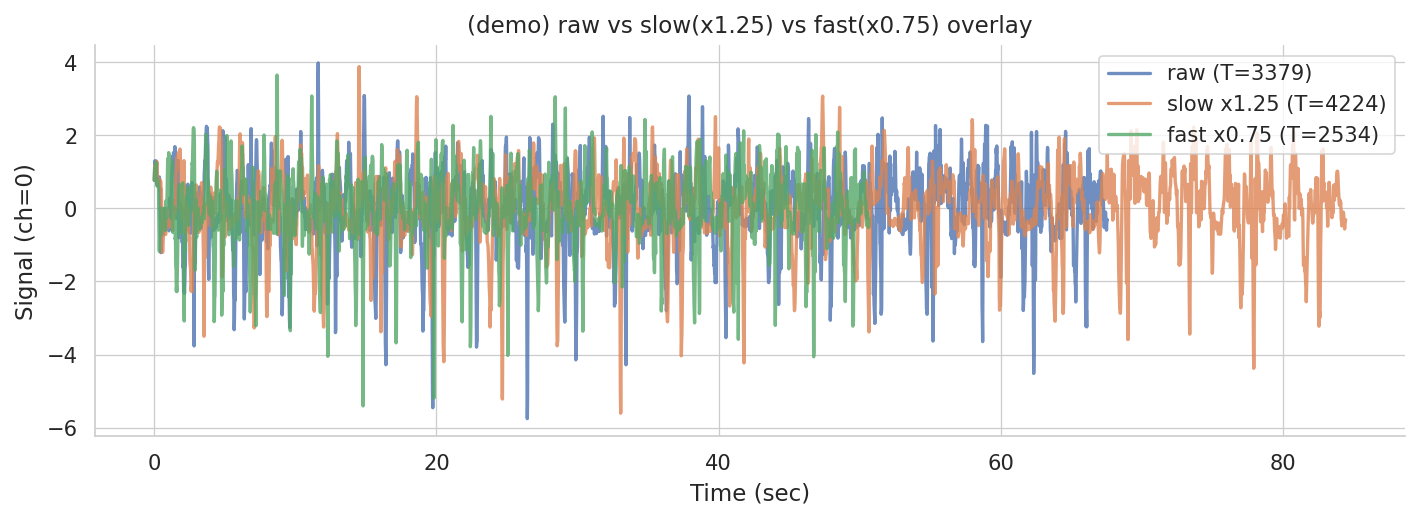

[Knees bending] Fold  1 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  2 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  3 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  4 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  5 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  6 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  7 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  8 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold  9 done (trained on 9 subj, swept 10 mults)
[Knees bending] Fold 10 done (trained on 9 subj, swept 10 mults)
[Saved] sweep rows -> sweep_results/sweep_act8_Knees_bending.csv

------------------------------------------------------------------------------------------
[Knees bending] ALL SWEEP ROWS (Subject × mult) | n=100
------------------------------------------------------------------------------------------
 mult   Subject   GT      Pred       MAE    MA

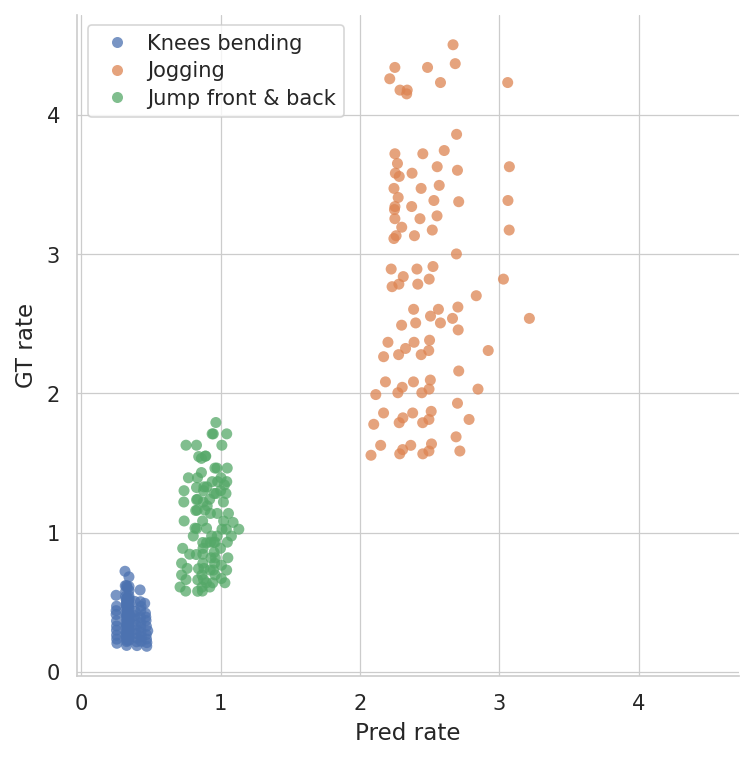

[Saved] scatter png -> sweep_results/scatter_PredRate_vs_GTRate_all_activities.png


In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


# ---------------------------------------------------------------------
# Paper-style visualization
# ---------------------------------------------------------------------
def set_paper_style():
    sns.set_theme(context="paper", style="whitegrid", font="DejaVu Sans", font_scale=1.15)
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "lines.linewidth": 1.6,
        "legend.frameon": True,
    })


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score (trial-wise)
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,              # (T,C)
                'count': float(gt_count),      # trial total count
                'meta': f"{subj}_{act_name}",
                'subj': subj,
                'act_id': act_id,
            })
        else:
            pass

    return trial_list


# ---------------------------------------------------------------------
# 2.5) Windowing
# ---------------------------------------------------------------------
def trial_list_to_windows(trial_list, fs, win_sec=8.0, stride_sec=4.0, drop_last=True):
    """
    TRAIN 전용: trial -> sliding windows
    window 라벨은 trial 평균 rate로부터 생성:
      rate_trial = count_total / total_duration
      count_window = rate_trial * window_duration
    """
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    assert win_len > 0 and stride > 0

    windows = []
    for item in trial_list:
        x = item["data"]  # (T,C)
        T = x.shape[0]
        total_count = float(item["count"])
        meta = item["meta"]

        total_dur = max(T / float(fs), 1e-6)
        rate_trial = total_count / total_dur  # reps/s

        if T < win_len:
            win_dur = T / float(fs)
            windows.append({
                "data": x,
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[0:{T}]",
            })
            continue

        last_start = T - win_len
        starts = list(range(0, last_start + 1, stride))

        for st in starts:
            ed = st + win_len
            win_dur = win_len / float(fs)
            windows.append({
                "data": x[st:ed],
                "count": rate_trial * win_dur,
                "meta": f"{meta}__win[{st}:{ed}]",
            })

        if not drop_last:
            last_st = starts[-1] + stride
            if last_st < T:
                ed = T
                win_dur = (ed - last_st) / float(fs)
                windows.append({
                    "data": x[last_st:ed],
                    "count": rate_trial * win_dur,
                    "meta": f"{meta}__win[{last_st}:{ed}]",
                })

    return windows


def predict_count_by_windowing(model, x_np, fs, win_sec, stride_sec, device, tau=1.0, batch_size=64):
    """
    TEST 전용: trial -> windows inference -> window rate 평균 -> total count
    x_np: (T,C) numpy (정규화된 상태)
    return: pred_count(float)
    """
    win_len = int(round(win_sec * fs))
    stride = int(round(stride_sec * fs))
    T = x_np.shape[0]
    total_dur = T / float(fs)

    # short trial -> 1회 forward
    if T <= win_len:
        x_tensor = torch.tensor(x_np, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)  # (1,C,T)
        with torch.no_grad():
            rate_hat, _, _, _ = model(x_tensor, mask=None, tau=tau)
        pred_count = float(rate_hat.item() * total_dur)
        return pred_count

    starts = list(range(0, T - win_len + 1, stride))
    windows = np.stack([x_np[st:st + win_len] for st in starts], axis=0)  # (N, win_len, C)
    xw = torch.tensor(windows, dtype=torch.float32).permute(0, 2, 1).to(device)  # (N,C,win_len)

    rates = []
    model.eval()
    with torch.no_grad():
        for i in range(0, xw.shape[0], batch_size):
            xb = xw[i:i + batch_size]
            r_hat, _, _, _ = model(xb, mask=None, tau=tau)
            rates.append(r_hat.detach().cpu().numpy())

    rates = np.concatenate(rates, axis=0)  # (N,)
    rate_mean = float(rates.mean())
    pred_count = rate_mean * total_dur
    return float(pred_count)


# ---------------------------------------------------------------------
# 2.6) ✅ Time-warp (TEST only)
# ---------------------------------------------------------------------
def time_warp_linear(x_np: np.ndarray, dur_mult: float) -> np.ndarray:
    """
    x_np: (T, C) float32
    dur_mult > 1.0  => 느리게(길어짐, T 증가)
    dur_mult < 1.0  => 빠르게(짧아짐, T 감소)

    구현: time axis 선형 보간 resample (채널별 독립)
    """
    assert x_np.ndim == 2, f"x_np must be (T,C), got {x_np.shape}"
    T, C = x_np.shape
    new_T = int(round(T * float(dur_mult)))
    new_T = max(new_T, 2)

    t_old = np.linspace(0.0, 1.0, T, dtype=np.float32)
    t_new = np.linspace(0.0, 1.0, new_T, dtype=np.float32)

    out = np.zeros((new_T, C), dtype=np.float32)
    for c in range(C):
        out[:, c] = np.interp(t_new, t_old, x_np[:, c]).astype(np.float32)
    return out


def plot_warp_overlay(raw_x, slow_x, fast_x, fs, ch=0, title="Time-warp overlay (raw/slow/fast)"):
    # 논문에 싣는 용도라기보단 데모/검증용이므로 너무 크지 않게 조정
    t_raw  = np.arange(raw_x.shape[0])  / float(fs)
    t_slow = np.arange(slow_x.shape[0]) / float(fs)
    t_fast = np.arange(fast_x.shape[0]) / float(fs)

    fig, ax = plt.subplots(figsize=(9.6, 3.6))
    ax.plot(t_raw,  raw_x[:, ch],  alpha=0.8, label=f"raw (T={raw_x.shape[0]})")
    ax.plot(t_slow, slow_x[:, ch], alpha=0.8, label=f"slow x1.25 (T={slow_x.shape[0]})")
    ax.plot(t_fast, fast_x[:, ch], alpha=0.8, label=f"fast x0.75 (T={fast_x.shape[0]})")
    ax.set_title(title)
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel(f"Signal (ch={ch})")
    ax.legend(loc="upper right")
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


# ---------------------------------------------------------------------
# 2.8) Dataset / Collate
# ---------------------------------------------------------------------
class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),         # (B, C, T_max)
        "mask": torch.stack(masks),               # (B, T_max)
        "count": torch.stack(counts),             # (B,)
        "length": torch.tensor(lengths, dtype=torch.float32),  # (B,)
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        z = self.net(x)            # (B,D,T)
        z = z.transpose(1, 2)      # (B,T,D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        zt = z.transpose(1, 2)     # (B,D,T)
        x_hat = self.net(zt)       # (B,C,T)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)  # [amp | phase_logits...]
        )

    def forward(self, z, tau=1.0):
        out = self.net(z)                     # (B,T,1+K)
        amp = F.softplus(out[..., 0])         # (B,T) >=0
        phase_logits = out[..., 1:]           # (B,T,K)
        phase = F.softmax(phase_logits / tau, dim=-1)
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        z = self.encoder(x)              # (B,T,D)
        x_hat = self.decoder(z)          # (B,C,T)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=tau)
        micro_rate_t = amp_t             # (B,T)

        p_bar = self._masked_mean_time(phase_p, mask)           # (B,K)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)          # (B,)

        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6) # (B,T)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "phase_p": phase_p,          # (B,T,K)
            "rep_rate_t": rep_rate_t,    # (B,T)
            "k_hat": k_hat,              # (B,)
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)              # (B,1,T)
    se = (x_hat - x) ** 2                    # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    dv = torch.abs(v[:, 1:] - v[:, :-1])
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)  # (B,T)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    if mask is None:
        p_bar = phase_p.mean(dim=1)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)
    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean()


def compute_phase_entropy_mean(phase_p_np, eps=1e-8):
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)  # (T,K)
    ent_t = -(phase_p_np * np.log(phase_p_np + eps)).sum(axis=1)
    return float(ent_t.mean())


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)
        mask = batch["mask"].to(device)
        y_count = batch["count"].to(device)
        length = batch["length"].to(device)

        duration = torch.clamp(length / fs, min=1e-6)
        y_rate = y_count / duration

        optimizer.zero_grad()
        rate_hat, _, x_hat, aux = model(x, mask, tau=tau)

        loss_rate = F.mse_loss(rate_hat, y_rate)
        loss_recon = masked_recon_mse(x_hat, x, mask)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)
        loss_effk = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()


# ---------------------------------------------------------------------
# 6) ✅ Added helpers for SWEEP + breakpoint + plots
# ---------------------------------------------------------------------
def _safe_div(a, b, eps=1e-6):
    return a / (b + eps)


def _find_breakpoints_by_mape(group_df, mape_thr=35.0):
    """
    group_df columns expected: ['mult', 'MAPE_mean'] sorted by mult
    return: (bp_fast, bp_slow)
      - bp_fast: mult < 1 side, moving away from 1: 1.0 -> ... -> smaller
      - bp_slow: mult > 1 side, moving away from 1: 1.0 -> ... -> larger
    """
    fast = group_df[group_df["mult"] < 1.0].sort_values("mult", ascending=False)
    bp_fast = None
    for _, r in fast.iterrows():
        if float(r["MAPE_mean"]) > float(mape_thr):
            bp_fast = float(r["mult"])
            break

    slow = group_df[group_df["mult"] > 1.0].sort_values("mult", ascending=True)
    bp_slow = None
    for _, r in slow.iterrows():
        if float(r["MAPE_mean"]) > float(mape_thr):
            bp_slow = float(r["mult"])
            break

    return bp_fast, bp_slow


def plot_all_activities_gtrate_predrate_scatter(df_all, out_png_path):
    """
    - scatter plot only
    - no title
    - axis labels: Pred rate / GT rate
    - legend inside plot
    - square plot (equal scaling) + dpi 600 png save
    """
    fig, ax = plt.subplots(figsize=(5.2, 5.2))  # ✅ square figure

    sns.scatterplot(
        data=df_all,
        x="Pred_rate",
        y="GT_rate",
        hue="Activity",
        s=28,
        alpha=0.75,
        edgecolor="none",
        ax=ax
    )

    # ✅ equal limits (same scale on both axes) for clean, square-looking plot
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lo = float(min(xmin, ymin))
    hi = float(max(xmax, ymax))
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # ✅ make axis square
    ax.set_aspect("equal", adjustable="box")

    # ✅ no title
    ax.set_title("")

    # ✅ labels
    ax.set_xlabel("Pred rate")
    ax.set_ylabel("GT rate")

    # ✅ legend inside
    ax.legend(
        title="",
        loc="upper left",
        frameon=True,
        borderpad=0.4,
        handletextpad=0.4,
        labelspacing=0.35
    )

    sns.despine(ax=ax)
    plt.tight_layout()

    fig.savefig(out_png_path, dpi=600, format="png", bbox_inches="tight")
    plt.show()
    plt.close(fig)


def _summarize_subjectwise_for_mult(df_act, mult, exp_name):
    dfm = df_act[np.isclose(df_act["mult"].values.astype(np.float32), float(mult), atol=1e-6)].copy()
    if len(dfm) == 0:
        return None, None

    df_subj = dfm.sort_values("Subject_ID").reset_index(drop=True)[
        ["Subject", "Pred", "GT", "MAE", "MAPE(%)", "Bias", "k_hat"]
    ].copy()

    mae_mean, mae_std = df_subj["MAE"].mean(), df_subj["MAE"].std()
    mape_mean, mape_std = df_subj["MAPE(%)"].mean(), df_subj["MAPE(%)"].std()
    bias_mean, bias_std = df_subj["Bias"].mean(), df_subj["Bias"].std()
    kh_mean, kh_std = df_subj["k_hat"].mean(), df_subj["k_hat"].std()

    summary = {
        "Experiment": exp_name,
        "MAE_mean": mae_mean, "MAE_std": mae_std,
        "MAPE_mean": mape_mean, "MAPE_std": mape_std,
        "Bias_mean": bias_mean, "Bias_std": bias_std,
        "k_hat_mean": kh_mean, "k_hat_std": kh_std,
        "n": len(df_subj)
    }
    return df_subj, summary


# ---------------------------------------------------------------------
# 7) Main
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],

        "TARGET_ACTIVITIES_MAP": {
            8: 'Knees bending',
            10: 'Jogging',
            12: 'Jump front & back'
        },

        "ACT_FEATURE_MAP": {
            8: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                ],
            10: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ],
            12: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                 'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
                 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
                 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                 'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z'
                 ]
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Windowing Params
        "win_sec": 8.0,
        "stride_sec": 4.0,
        "drop_last": True,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.0075,

        "tau": 1.0,

        # ✅ dict 형태 GT
        "ALL_LABELS_DICT": {
            8: {
                "subject1": 20, "subject2": 21, "subject3": 21, "subject4": 19, "subject5": 20,
                "subject6": 20, "subject7": 21, "subject8": 21, "subject9": 21, "subject10": 21,
            },
            10: {
                "subject1": 157, "subject2": 161, "subject3": 154, "subject4": 154, "subject5": 160,
                "subject6": 156, "subject7": 153, "subject8": 160, "subject9": 166, "subject10": 156,
            },
            12: {
                "subject1": 20, "subject2": 22, "subject3": 21, "subject4": 21, "subject5": 20,
                "subject6": 21, "subject7": 19, "subject8": 20, "subject9": 20, "subject10": 20,
            },
        },
    }

    # ------------------------------------------------------------------
    # ✅ Sweep config (요구사항)
    # ------------------------------------------------------------------
    SWEEP_MULTS = [0.6, 0.7, 0.75, 0.8, 0.9, 1.0, 1.1, 1.25, 1.4, 1.6]
    MAPE_BREAKPOINT = 35.0  # ✅ fixed

    # (원 코드 유지) 결과 csv 저장 경로
    OUT_DIR = "sweep_results"
    os.makedirs(OUT_DIR, exist_ok=True)

    set_paper_style()

    # ------------------------------------------------------------------
    # helper: dict -> label_config(list of tuples)
    # ------------------------------------------------------------------
    def labels_from_dict(labels_dict, act_id, include_subjects):
        out = []
        for subj in include_subjects:
            if subj not in labels_dict[act_id]:
                print(f"[Skip] Missing GT count for {subj} act_id={act_id}")
                continue
            out.append((subj, act_id, float(labels_dict[act_id][subj])))
        return out

    # ------------------------------------------------------------------
    # init
    # ------------------------------------------------------------------
    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]

    print("\n" + "-" * 90)
    print(" >>> Starting LOSO (count-only, K-auto) + WINDOWING + TEST time-warp SWEEP")
    print("-" * 90)

    # ✅ 전체 활동 결과 모아서 "한 plot"에 찍기 위한 리스트
    df_all_acts_list = []

    # ------------------------------------------------------------------
    # ✅ Activity-wise sweep (train once per fold, test multiple mults)
    # ------------------------------------------------------------------
    for act_id in [8, 10, 12]:
        act_name = CONFIG["TARGET_ACTIVITIES_MAP"][act_id]
        print("\n" + "=" * 90)
        print(f" >>> SWEEP | Activity: {act_name} (act_id={act_id})")
        print("=" * 90)

        rows = []

        for fold_idx, test_subj in enumerate(subjects):
            set_strict_seed(CONFIG["seed"])

            train_subjects = [s for s in subjects if s != test_subj]
            test_subjects = [test_subj]

            train_labels = labels_from_dict(CONFIG["ALL_LABELS_DICT"], act_id, train_subjects)
            test_labels = labels_from_dict(CONFIG["ALL_LABELS_DICT"], act_id, test_subjects)

            train_trials = prepare_trial_list(
                train_labels, full_data,
                CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"]
            )
            test_trials = prepare_trial_list(
                test_labels, full_data,
                CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"]
            )

            if not test_trials:
                print(f"[Skip] Fold {fold_idx + 1}: {test_subj} has no data.")
                continue

            train_data = trial_list_to_windows(
                train_trials,
                fs=CONFIG["fs"],
                win_sec=CONFIG["win_sec"],
                stride_sec=CONFIG["stride_sec"],
                drop_last=CONFIG["drop_last"]
            )

            g = torch.Generator()
            g.manual_seed(CONFIG["seed"])

            train_loader = DataLoader(
                TrialDataset(train_data),
                batch_size=CONFIG["batch_size"],
                shuffle=True,
                collate_fn=collate_variable_length,
                generator=g,
                num_workers=0
            )

            input_ch = train_data[0]['data'].shape[1]
            model = KAutoCountModel(
                input_ch=input_ch,
                hidden_dim=CONFIG["hidden_dim"],
                latent_dim=CONFIG["latent_dim"],
                K_max=CONFIG["K_max"]
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

            for epoch in range(CONFIG["epochs"]):
                _ = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
                scheduler.step()

            model.eval()

            item = test_trials[0]
            x_np_raw = item["data"]  # (T,C) normalized
            count_gt = float(item["count"])

            if act_id == 8 and fold_idx == 0:
                slow_demo = time_warp_linear(x_np_raw, 1.25)
                fast_demo = time_warp_linear(x_np_raw, 0.75)
                plot_warp_overlay(
                    x_np_raw, slow_demo, fast_demo,
                    fs=CONFIG["fs"],
                    ch=0,
                    title="(demo) raw vs slow(x1.25) vs fast(x0.75) overlay"
                )

            for mult in SWEEP_MULTS:
                x_np_warp = time_warp_linear(x_np_raw, dur_mult=float(mult))

                count_pred = predict_count_by_windowing(
                    model,
                    x_np=x_np_warp,
                    fs=CONFIG["fs"],
                    win_sec=CONFIG["win_sec"],
                    stride_sec=CONFIG["stride_sec"],
                    device=device,
                    tau=CONFIG.get("tau", 1.0),
                    batch_size=CONFIG.get("batch_size", 64)
                )

                dur = x_np_warp.shape[0] / float(CONFIG["fs"])
                gt_rate = count_gt / max(dur, 1e-6)
                pred_rate = count_pred / max(dur, 1e-6)

                abs_err = abs(count_pred - count_gt)
                mape = abs_err / (abs(count_gt) + 1e-6) * 100.0
                bias = (count_pred - count_gt)

                x_tensor = torch.tensor(x_np_warp, dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                with torch.no_grad():
                    _, _, _, aux = model(x_tensor, mask=None, tau=CONFIG.get("tau", 1.0))
                k_hat = float(aux["k_hat"].item())

                rows.append({
                    "Activity": act_name,
                    "act_id": int(act_id),
                    "mult": float(mult),
                    "Subject_ID": int(''.join(filter(str.isdigit, test_subj))),
                    "Subject": test_subj,
                    "Pred": float(count_pred),
                    "GT": float(count_gt),
                    "MAE": float(abs_err),
                    "MAPE(%)": float(mape),
                    "Bias": float(bias),
                    "k_hat": float(k_hat),
                    "duration_sec": float(dur),
                    "GT_rate": float(gt_rate),
                    "Pred_rate": float(pred_rate),
                })

            print(f"[{act_name}] Fold {fold_idx + 1:2d} done (trained on 9 subj, swept {len(SWEEP_MULTS)} mults)")

        if len(rows) == 0:
            print(f"[{act_name}] No results.")
            continue

        df_act = pd.DataFrame(rows).sort_values(["mult", "Subject_ID"]).reset_index(drop=True)

        # (원 코드 유지) raw sweep rows 저장
        csv_path = os.path.join(OUT_DIR, f"sweep_act{act_id}_{act_name.replace(' ', '_').replace('&', 'and')}.csv")
        df_act.to_csv(csv_path, index=False)
        print(f"[Saved] sweep rows -> {csv_path}")

        # ✅ (추가) 모든 sweep rows 출력 (activity당 10 subjects × 10 mults = 100 rows 수준)
        print("\n" + "-" * 90)
        print(f"[{act_name}] ALL SWEEP ROWS (Subject × mult) | n={len(df_act)}")
        print("-" * 90)
        with pd.option_context('display.max_rows', 400, 'display.max_columns', 50, 'display.width', 160):
            print(df_act[[
                "mult", "Subject", "GT", "Pred", "MAE", "MAPE(%)", "Bias", "GT_rate", "Pred_rate", "k_hat"
            ]].to_string(index=False))

        # ------------------------------------------------------------------
        # ✅ (추가) mult별 Count-error summary (MAPE/MAE/Bias) 출력 + CSV
        # ------------------------------------------------------------------
        gdf = (df_act.groupby("mult")
               .agg(
                    n=("MAPE(%)", "count"),
                    MAPE_mean=("MAPE(%)", "mean"),
                    MAPE_std=("MAPE(%)", "std"),
                    MAE_mean=("MAE", "mean"),
                    MAE_std=("MAE", "std"),
                    Bias_mean=("Bias", "mean"),
                    Bias_std=("Bias", "std"),
               )
               .reset_index()
               .sort_values("mult")
               .reset_index(drop=True))

        bp_fast, bp_slow = _find_breakpoints_by_mape(gdf, mape_thr=MAPE_BREAKPOINT)

        print("\n" + "-" * 90)
        print(f"[{act_name}] Breakpoints by mean MAPE > {MAPE_BREAKPOINT:.1f}%")
        print("-" * 90)
        print(f"  fast side (mult < 1): {bp_fast}")
        print(f"  slow side (mult > 1): {bp_slow}")
        print("-" * 90)

        print("\n" + "-" * 90)
        print(f"[{act_name}] COUNT ERROR SUMMARY per mult (mean±std)")
        print("-" * 90)
        with pd.option_context('display.max_rows', 200, 'display.max_columns', 50, 'display.width', 160):
            print(gdf.to_string(index=False))

        gdf_csv = os.path.join(
            OUT_DIR,
            f"sweep_summary_mape_act{act_id}_{act_name.replace(' ', '_').replace('&', 'and')}.csv"
        )
        gdf.to_csv(gdf_csv, index=False)
        print(f"[Saved] summary (MAPE/MAE/Bias by mult) -> {gdf_csv}")

        # ------------------------------------------------------------------
        # ✅ (추가) mult별 GT_rate / Pred_rate summary 출력 + CSV
        # ------------------------------------------------------------------
        rdf = (df_act.groupby("mult")
               .agg(
                    n=("GT_rate", "count"),
                    GT_rate_mean=("GT_rate", "mean"),
                    GT_rate_std=("GT_rate", "std"),
                    Pred_rate_mean=("Pred_rate", "mean"),
                    Pred_rate_std=("Pred_rate", "std"),
               )
               .reset_index()
               .sort_values("mult")
               .reset_index(drop=True))

        print("\n" + "-" * 90)
        print(f"[{act_name}] RATE SUMMARY per mult (mean±std)")
        print("-" * 90)
        with pd.option_context('display.max_rows', 200, 'display.max_columns', 50, 'display.width', 160):
            print(rdf.to_string(index=False))

        rdf_csv = os.path.join(
            OUT_DIR,
            f"sweep_summary_rate_act{act_id}_{act_name.replace(' ', '_').replace('&', 'and')}.csv"
        )
        rdf.to_csv(rdf_csv, index=False)
        print(f"[Saved] summary (GT_rate/Pred_rate by mult) -> {rdf_csv}")

        # ✅ "한 plot에 3개 활동"을 위해 activity별 df를 모아둠
        df_all_acts_list.append(df_act[["Activity", "GT_rate", "Pred_rate"]].copy())

    # ------------------------------------------------------------------
    # ✅ Scatter plot only: 한 plot에 3개 활동 점들을 색 구분 + PNG 저장
    # ------------------------------------------------------------------
    if len(df_all_acts_list) > 0:
        df_all = pd.concat(df_all_acts_list, axis=0, ignore_index=True)
        out_png = os.path.join(OUT_DIR, "scatter_PredRate_vs_GTRate_all_activities.png")
        plot_all_activities_gtrate_predrate_scatter(df_all, out_png)
        print(f"[Saved] scatter png -> {out_png}")


if __name__ == "__main__":
    main()
